## Speed dating data-set
#### Joris Rombouts - November 2017

### 1.3 Feature Engineering

### <font color="green">imports, preparation and configuration</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# imports needed for the visualization and exportation of visualizations
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
import io
from scipy import misc

In [3]:
df = pd.read_csv("speed_dating_assignment.csv")
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The model should be trained to build the class attribute <i>dec</i>. To help and improve the models, one can introduce new (calculated) features. These features should optimize the performance metric. Just as in 1.2, the attributes with a lot of missing values (NaN) are not very usefull for the model. Because this is a small size of dataset, the NaN values won't be filled in. 
This improved model is built on the model of 1.2, with some extra new calculated features. For introducing new calculated features, the attributes of the partner need to be accessed by cross-referencing it (using <i>pid == iid </i>. In addition to the attributes that are used in 1.2, the following features are added to the dataframe:

* <b>age_diff</b> <i>absolute difference between subject's age and partners age (age_o, see 1.1)</i> As concluded in 1.1, the number of decisions that a participant wanted to see a partner again was higher when there was a low age difference between the two. One can also imagine that the lower the age difference, people find it easier to communicate. Therefore, it could be that this is a important attribute on which the decision tree can split. 
* <b>attr_o</b> <i>rating by partner the night of the event, for all six attributes (attr,sinc,intel,fun,amb and shar)</i> Each participant rate their partner on six attributes on a scale of 1 -10 (1=awful, 10 = great). Therefore, the higher each partner scores, the better. So adding all these ratings to a total rating , which could be maximum a score of 60, could be a good indicidation whether the participant want to see their partner again. Note that these ratings are the same for all waves (except from the other ratings), so we don't need to convert them. 
* <b>race_equals</b> <i>boolean value, which is True if the race of the partner equals the race of the participant and False otherwise</i> One can imagine that people from the same race have similarities in their daily habits and culture in general. Therefore it could be interesting to see when participant and partner are from the same race, this increases the chance of seeing each other again. 
* <b>goal_equals</b> <i>boolean value, which is True if the goal of the partner equals the goal of the participant and False otherwise </i> When both people go on date with the same purpose, for example "looking for a serious relationship" or "to get a date", this could be increasing the fact that they wanted to see their partner again or not. When subjects have a different or the same primary goal, this could influence their decision. 

In [4]:
df_o = df.copy()
df_o = df_o.filter(items=['iid', 'age', 'race', 'goal'])
df_o.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
df_o = df_o.drop_duplicates()

df_new = pd.merge(df, df_o, on=['pid'], how = 'left')

In [5]:
df =df_new.copy()

Just as in 1.2, only the missing values of age are filled in by the mean of the column. We don't do this for the other attributes, because this will affect the correctness of the model too much , as explained earlier in 1.2.

In [6]:
df = df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner']]
df.age.fillna(df.age.median(), inplace = True)
print(df.shape)
df.info()

(8378, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8378 entries, 0 to 8377
Data columns (total 22 columns):
attr            8176 non-null float64
sinc            8101 non-null float64
intel           8082 non-null float64
fun             8028 non-null float64
amb             7666 non-null float64
shar            7311 non-null float64
gender          8378 non-null int64
order           8378 non-null int64
goal            8299 non-null float64
field_cd        8296 non-null float64
date            8281 non-null float64
age             8378 non-null float64
go_out          8299 non-null float64
imprace         8299 non-null float64
imprelig        8299 non-null float64
dec             8378 non-null int64
age_o           8274 non-null float64
race            8315 non-null float64
pid             8368 non-null object
iid             8378 non-null int64
race_partner    8305 non-null float64
goal_partner    8289 non-null float64
dtypes: float64(17), int64(4), object(1)
memory usage: 

In [7]:
df = df.dropna().reset_index(drop=True)

### <font color="green">Calculating new features</font>

This paragraph covers the calculations of the new features that are introduced in the dataframe. The <i>attr_o</i> attribute is calculated by summing up all the six attributes. After that these attributes are deleted from the dataframe, so that they won't have influence anymore on the predictive model will be created in the next paragraph. The other calculations are rather straightforward.

In [8]:
df['attr_o'] = df['attr'] + df['sinc'] + df['intel'] + df['fun'] + df['amb'] + df['shar']
df = df.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)

In [9]:
df['age_diff'] = abs(df['age'] - df['age_o'])

In [10]:
df['race_equals'] = (df['race'] == df['race_partner'])

In [11]:
df['goal_equals'] = df.apply(lambda r: r.goal == r.goal_partner, axis = 1)

In [12]:
df = df[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'dec','age_diff', 'attr_o','race_equals', 'goal_equals']]
df.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,dec,age_diff,attr_o,race_equals,goal_equals
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,6.0,40.0,False,False
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,41.0,False,False
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,1.0,42.0,True,True
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,2.0,42.0,False,True
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,1,3.0,37.0,False,False


Since also this model needs to be trained for two seperate genders (males and females), the data is seperated into a dataframe for the male daters and a data frame for the female daters.

In [13]:
male_subjects = df[df.gender == 1]
female_subjects = df[df.gender == 0]
male_subjects.shape, female_subjects.shape

((3455, 14), (3384, 14))

There are 3455 records in the data set of the male subjects and 3384 records in the data set of the female subjects. Not that for both the male and female dataframe these are less records than in 1.2. This is because this model includes extra attributes (<i>race</i>, <i>goal</i> and all the six attributes). These attributes also contained some NaN values, which were dropped.  

### <font color="green">Training the models</font>

The rows are shuffled to ensure a fair split into training and test data. The same steps as in 1.2 are repeated.

In [14]:
male_subjects_shuffle = male_subjects.sample(frac=1).reset_index(drop=True) # shuffle rows
female_subjects_shuffle = female_subjects.sample(frac=1).reset_index(drop=True)

In [15]:
male_x_data = male_subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
female_x_data = female_subjects_shuffle.drop('dec', axis = 1)
male_labels = male_subjects_shuffle['dec']
female_labels = female_subjects_shuffle['dec']

The data is split into 80% training data and 20% test data.

In [16]:
male_x_train, male_x_test, male_y_train, male_y_test = train_test_split(male_x_data, male_labels, test_size = 0.2)
female_x_train, female_x_test, female_y_train, female_y_test = train_test_split(female_x_data, female_labels, test_size = 0.2)

To compare the models to each other and to the models using only the raw features (1.2), decision tree learning is going to be used to train the models. The target variable <i>dec</i> is unchanged.

In [17]:
dec_tree_male = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
dec_tree_female = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 8, min_samples_split = 50, min_samples_leaf = 12)
# build decision tree classifiers from the training sets
dec_tree_male.fit(male_x_train, male_y_train)
dec_tree_female.fit(female_x_train, female_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### <font color="green">Visualizing the models</font>

The next function is only for visualizing the decision trees in a nice way.

In [18]:
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

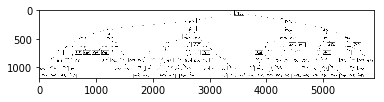

In [19]:
male_col_names = dec_tree_male.classes_
male_feature_names = male_subjects.columns[0:(male_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_male, "male_decision_tree(1.3).png", male_col_names, male_feature_names)

See Appendix A.3 for the full image (uncropped)

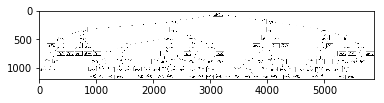

In [20]:
female_col_names = dec_tree_female.classes_
female_feature_names = female_subjects.columns[0:(female_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_female, "female_decision_tree(1.3).png", female_col_names, female_feature_names)

See Appendix A.4 for the full image (uncropped)

### <font color="green">Evaluating the performance of the models</font>

In [ ]:
pred_male = dec_tree_male.predict(male_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(male_y_test, pred_male))

In [ ]:
pred_female = dec_tree_female.predict(female_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(female_y_test, pred_female))

In [ ]:
print(metrics.classification_report(male_y_test, pred_male))

In [ ]:
print(metrics.classification_report(female_y_test, pred_female))

### <font color="green">Comparing the differences among the models</font>